In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Analisi scientifica
from scipy import signal, stats
from scipy.signal import welch, spectrogram, hilbert, medfilt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.fft import fft, fftfreq

In [7]:
import os
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.fft import fft, fftfreq

def parse_vibration_dataset(dataset_path):
    """
    Parsa il dataset di vibrazione e crea un DataFrame pandas con una riga per ogni file.
    Versione corretta che gestisce i pattern dei nomi file.
    """
    data_list = []
    unrecognized_files = []

    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.txt'):
                folder_name = os.path.basename(root)
                
                # Estrai l'etichetta dal nome della cartella
                if 'Pitting_degradation_level_' in folder_name:
                    etichetta_full = folder_name.replace('Pitting_degradation_level_', '')
                    if '(' in etichetta_full:
                        etichetta = etichetta_full.split('(')[0].strip()
                        descrizione = etichetta_full.split('(')[1].replace(')', '').strip()
                    else:
                        etichetta = etichetta_full.strip()
                        descrizione = None
                else:
                    # Se non segue il pattern, usa il nome della cartella come etichetta
                    etichetta = folder_name
                    descrizione = None

                # Pattern corretto per i nomi dei file (con underscore)
                pattern = r'V(\d+)_(\d+)N_(\d+)\.txt'
                match = re.search(pattern, file)

                if match:
                    velocita = int(match.group(1))
                    torque = int(match.group(2))
                    rep = int(match.group(3))

                    file_path = os.path.join(root, file)
                    try:
                        # Carica tutti i dati del file
                        data = np.loadtxt(file_path)
                        
                        # Verifica che il file abbia almeno 4 colonne
                        if data.shape[1] < 4:
                            print(f"Attenzione: {file} ha solo {data.shape[1]} colonne")
                            continue
                        
                        # Calcola informazioni aggiuntive
                        sampling_rate = 20480  # Hz
                        duration = len(data) / sampling_rate
                        
                        # Crea il record
                        record = {
                            'file_name': file,
                            'etichetta': etichetta,
                            'health_level': int(etichetta) if etichetta.isdigit() else etichetta,
                            'velocita': velocita,
                            'torque': torque,
                            'rep': rep,
                            'horizontal_acceleration': data[:, 0],
                            'axial_acceleration': data[:, 1],
                            'vertical_acceleration': data[:, 2],
                            'tachometer_signal': data[:, 3],
                            'sampling_rate': sampling_rate,
                            'duration': duration,
                            'num_samples': len(data),
                            'descrizione': descrizione,
                            'folder_name': folder_name
                        }
                        data_list.append(record)

                    except Exception as e:
                        print(f"Errore nel leggere il file {file_path}: {e}")
                        continue
                else:
                    unrecognized_files.append(file)
                    # Prova anche pattern alternativi
                    alternative_patterns = [
                        r'V(\d+)(\d+)N(\d+)\.txt',  # Senza underscore
                        r'V(\d+)_(\d+)N(\d+)\.txt',  # Con un underscore
                    ]
                    
                    for alt_pattern in alternative_patterns:
                        alt_match = re.search(alt_pattern, file)
                        if alt_match:
                            print(f"File {file} riconosciuto con pattern alternativo: {alt_pattern}")
                            # Processa con il pattern alternativo
                            break

    # Mostra alcuni file non riconosciuti per debug
    if unrecognized_files:
        print(f"\nPrimi 10 file non riconosciuti:")
        for file in unrecognized_files[:10]:
            print(f"  {file}")
        print(f"Totale file non riconosciuti: {len(unrecognized_files)}")

    df = pd.DataFrame(data_list)

    if not df.empty:
        df = df.sort_values(['health_level', 'velocita', 'torque', 'rep']).reset_index(drop=True)
        print(f"\nDataset caricato: {len(df)} file processati")
        print(f"Health levels disponibili: {sorted(df['health_level'].unique())}")
        print(f"Condizioni operative (rpm): {sorted(df['velocita'].unique())}")
        print(f"Condizioni operative (torque): {sorted(df['torque'].unique())}")
        print(f"Colonne nel DataFrame: {list(df.columns)}")
    else:
        print("ATTENZIONE: Nessun file è stato processato con successo!")
        print("Controlla:")
        print("1. Il percorso del dataset")
        print("2. La struttura delle cartelle")
        print("3. I pattern dei nomi dei file")

    return df


def extract_signal_features(df, signal_column):
    """
    Estrae features statistiche e nel dominio della frequenza da una colonna di segnali.
    """
    features_list = []
    
    for idx, row in df.iterrows():
        signal = row[signal_column]
        
        # Features statistiche nel dominio del tempo
        features = {
            f'{signal_column}_mean': np.mean(signal),
            f'{signal_column}_std': np.std(signal),
            f'{signal_column}_rms': np.sqrt(np.mean(signal**2)),
            f'{signal_column}_peak': np.max(np.abs(signal)),
            f'{signal_column}_peak_to_peak': np.ptp(signal),
            f'{signal_column}_skewness': stats.skew(signal),
            f'{signal_column}_kurtosis': stats.kurtosis(signal),
            f'{signal_column}_crest_factor': np.max(np.abs(signal)) / np.sqrt(np.mean(signal**2)) if np.sqrt(np.mean(signal**2)) > 0 else 0,
        }
        
        # Features nel dominio della frequenza
        sampling_rate = row['sampling_rate']
        fft_vals = np.abs(fft(signal))
        freqs = fftfreq(len(signal), 1/sampling_rate)
        
        # Considera solo le frequenze positive
        positive_freq_idx = freqs > 0
        fft_positive = fft_vals[positive_freq_idx]
        freqs_positive = freqs[positive_freq_idx]
        
        if len(fft_positive) > 0:
            # Trova la frequenza dominante
            dominant_freq_idx = np.argmax(fft_positive)
            features[f'{signal_column}_dominant_freq'] = freqs_positive[dominant_freq_idx]
            features[f'{signal_column}_dominant_magnitude'] = fft_positive[dominant_freq_idx]
            
            # Features spettrali
            total_power = np.sum(fft_positive**2)
            if total_power > 0:
                features[f'{signal_column}_spectral_centroid'] = np.sum(freqs_positive * fft_positive**2) / total_power
                cumsum_power = np.cumsum(fft_positive**2)
                rolloff_idx = np.where(cumsum_power >= 0.85 * total_power)[0]
                if len(rolloff_idx) > 0:
                    features[f'{signal_column}_spectral_rolloff'] = freqs_positive[rolloff_idx[0]]
                else:
                    features[f'{signal_column}_spectral_rolloff'] = freqs_positive[-1]
            else:
                features[f'{signal_column}_spectral_centroid'] = 0
                features[f'{signal_column}_spectral_rolloff'] = 0
        else:
            features[f'{signal_column}_dominant_freq'] = 0
            features[f'{signal_column}_dominant_magnitude'] = 0
            features[f'{signal_column}_spectral_centroid'] = 0
            features[f'{signal_column}_spectral_rolloff'] = 0
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)


def debug_dataset_structure(dataset_path):
    """
    Funzione di debug per esplorare la struttura del dataset
    """
    print("=== DEBUG: Struttura del dataset ===")
    
    # Esplora le prime 3 cartelle e i primi 5 file per cartella
    folder_count = 0
    for root, dirs, files in os.walk(dataset_path):
        if folder_count >= 3:
            break
            
        print(f"\nCartella: {root}")
        print(f"  Sottocartelle: {dirs[:5]}")
        print(f"  File txt: {[f for f in files if f.endswith('.txt')][:5]}")
        
        folder_count += 1

# Esempio d'uso con debug:
if __name__ == "__main__":
    dataset_path = '../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data'
    
    # Prima esplora la struttura
    debug_dataset_structure(dataset_path)
    
    # Poi carica il dataset
    df = parse_vibration_dataset(dataset_path)
    
    if not df.empty:
        print("\n=== Estrazione features ===")
        
        # Estrai features da tutti i segnali di accelerazione
        horizontal_features = extract_signal_features(df, 'horizontal_acceleration')
        axial_features = extract_signal_features(df, 'axial_acceleration')
        vertical_features = extract_signal_features(df, 'vertical_acceleration')

        # Combina tutte le features
        features_df = pd.concat([
            df[['file_name', 'health_level', 'velocita', 'torque', 'rep']],
            horizontal_features,
            axial_features, 
            vertical_features
        ], axis=1)

        print(f"Features dataset shape: {features_df.shape}")
        print(f"Colonne features: {list(features_df.columns)}")
    else:
        print("Impossibile procedere con l'estrazione delle features: DataFrame vuoto")

=== DEBUG: Struttura del dataset ===

Cartella: ../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data
  Sottocartelle: ['Pitting_degradation_level_2', 'Pitting_degradation_level_3', 'Pitting_degradation_level_4', 'Pitting_degradation_level_8', 'Pitting_degradation_level_1']
  File txt: []

Cartella: ../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_2
  Sottocartelle: []
  File txt: ['V200_200N_1.txt', 'V200_300N_1.txt', 'V3000_50N_5.txt', 'V900_500N_4.txt', 'V500_200N_1.txt']

Cartella: ../data/raw/B - PHM America 2023 - Dataset/Data_Challenge_PHM2023_training_data/Pitting_degradation_level_3
  Sottocartelle: []
  File txt: ['V1200_50N_3.txt', 'V200_200N_1.txt', 'V900_500N_4.txt', 'V500_300N_1.txt', 'V900_400N_4.txt']

Dataset caricato: 2016 file processati
Health levels disponibili: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8)]
Condizioni operative (rpm): [np

In [8]:
df.head()

,file_name,etichetta,health_level,velocita,torque,rep,horizontal_acceleration,axial_acceleration,vertical_acceleration,tachometer_signal,sampling_rate,duration,num_samples,descrizione,folder_name
0,V100_50N_1.txt,0,0,100,50,1,"[-0.4626018245, -0.7124489885, -0.5509291238, ...","[-0.4991110174, -0.7377190438, -0.5699753646, ...","[-0.4254987892, -0.814484938, -0.5429899587, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None,Pitting_degradation_level_0
1,V100_50N_2.txt,0,0,100,50,2,"[0.08373725705, -0.01240551956, -0.05421212049...","[0.04308363971, -0.05226539899, -0.09993991833...","[0.0949569657, -0.06374649093, -0.1336386738, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None,Pitting_degradation_level_0
2,V100_50N_3.txt,0,0,100,50,3,"[-0.06376437055, 0.09676305259, -0.04503203601...","[-0.07804495389, 0.07745637958, -0.06497860415...","[-0.0985720786, 0.153401291, -0.08254507805, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None,Pitting_degradation_level_0
3,V100_50N_4.txt,0,0,100,50,4,"[0.07418500699, -0.03634817232, -0.08572214018...","[0.06933405406, -0.03107672372, -0.07251235535...","[0.1519552459, -0.01518347421, -0.08507565708,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None,Pitting_degradation_level_0
4,V100_50N_5.txt,0,0,100,50,5,"[-0.02816052941, 0.04416364964, 0.05731350038,...","[-0.06439002983, 0.02001152664, 0.03849276007,...","[-0.07965298772, 0.031089971, 0.06398749846, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20480,12.05,246784,None,Pitting_degradation_level_0


ESEMPI DI UTILIZZO:

1. MATRICE DI CORRELAZIONE SEMPLICE:
=== MATRICE DI CORRELAZIONE ===
          feature1  feature2  feature3  feature4  feature5
feature1     1.000    -0.136    -0.045    -0.136     0.928
feature2    -0.136     1.000    -0.034     0.191    -0.183
feature3    -0.045    -0.034     1.000     0.127    -0.051
feature4    -0.136     0.191     0.127     1.000    -0.168
feature5     0.928    -0.183    -0.051    -0.168     1.000

2. SOLO CORRELAZIONI SIGNIFICATIVE (|r| >= 0.3):
=== MATRICE DI CORRELAZIONE ===
(Mostrando solo correlazioni con |r| >= 0.3)
          feature1 feature2 feature3 feature4  feature5
feature1       1.0                             0.928427
feature2                1.0                            
feature3                         1.0                   
feature4                                  1.0          
feature5  0.928427                                  1.0

=== CORRELAZIONI ELEVATE (|r| >= 0.5) ===
Variable_1 Variable_2  Correlation
  feature1   fe

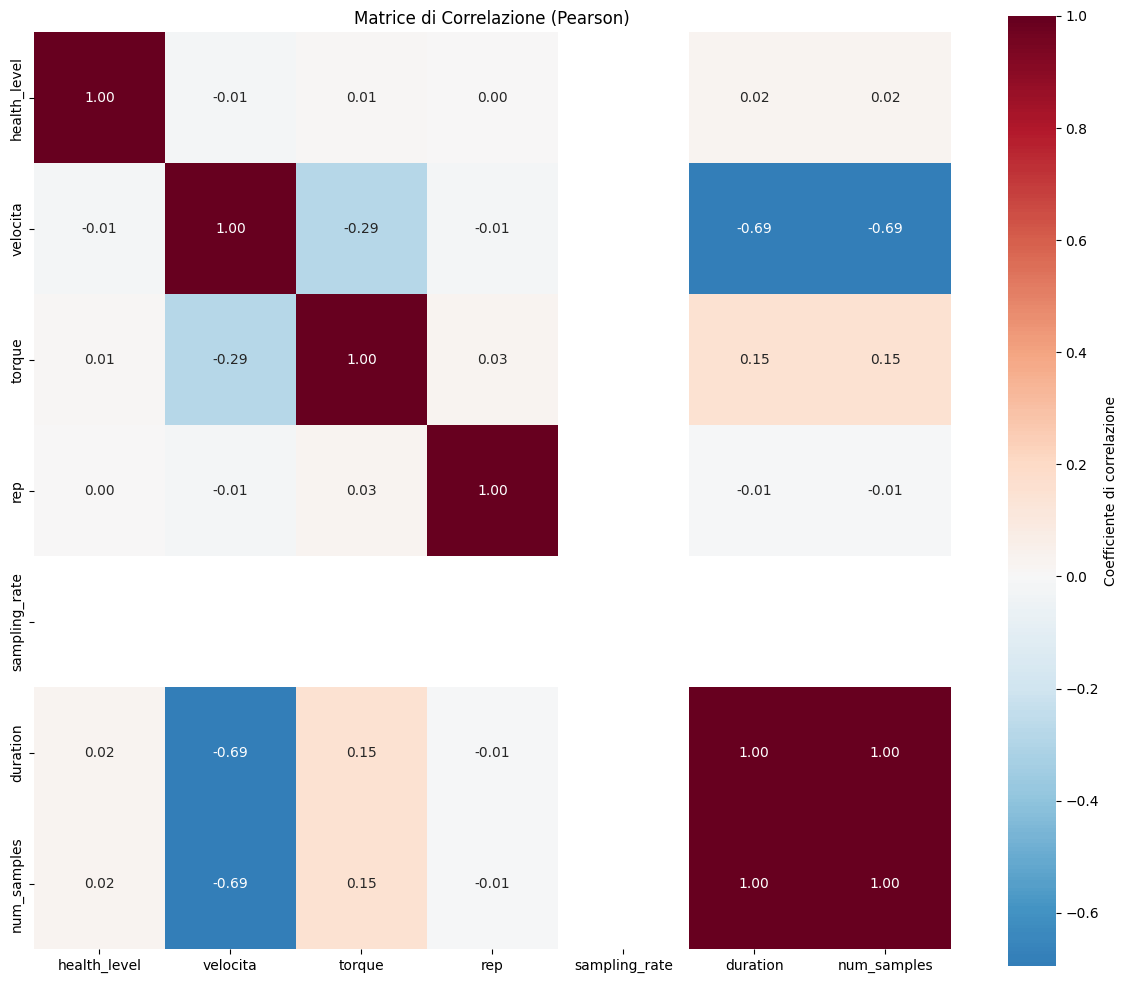

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def print_correlation_matrix(df, method='pearson', threshold=None):
    """
    Stampa la matrice di correlazione in formato tabellare
    
    Parameters:
    - df: DataFrame
    - method: 'pearson', 'spearman', 'kendall'
    - threshold: mostra solo correlazioni sopra questa soglia (in valore assoluto)
    """
    print("=== MATRICE DI CORRELAZIONE ===")
    corr_matrix = df.corr(method=method, numeric_only=True)
    
    if threshold is not None:
        print(f"(Mostrando solo correlazioni con |r| >= {threshold})")
        # Maschera i valori sotto la soglia
        mask = np.abs(corr_matrix) < threshold
        corr_matrix = corr_matrix.mask(mask, "")
    
    print(corr_matrix.round(3))
    return corr_matrix


def plot_correlation_heatmap(df, method='pearson', figsize=(10, 8), 
                           annot=True, title=None, save_path=None):
    """
    Crea una heatmap della correlazione
    
    Parameters:
    - df: DataFrame
    - method: metodo di correlazione
    - figsize: dimensione della figura
    - annot: se mostrare i valori numerici
    - title: titolo del grafico
    - save_path: percorso per salvare il grafico
    """
    # Calcola la matrice di correlazione solo per le colonne numeriche
    corr_matrix = df.corr(method=method, numeric_only=True)
    
    # Crea la figura
    plt.figure(figsize=figsize)
    
    # Crea la heatmap
    sns.heatmap(corr_matrix, 
                annot=annot,           # Mostra i valori
                cmap='RdBu_r',        # Colormap (rosso-blu invertita)
                center=0,             # Centra su 0
                square=True,          # Celle quadrate
                fmt='.2f',            # Formato numeri
                cbar_kws={'label': 'Coefficiente di correlazione'})
    
    plt.title(title or f'Matrice di Correlazione ({method.title()})')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_correlation_clustermap(df, method='pearson', figsize=(12, 10)):
    """
    Crea una clustermap che raggruppa variabili simili
    """
    corr_matrix = df.corr(method=method, numeric_only=True)
    
    # Clustermap con dendrogramma
    sns.clustermap(corr_matrix,
                   annot=True,
                   cmap='RdBu_r',
                   center=0,
                   square=True,
                   fmt='.2f',
                   figsize=figsize,
                   cbar_kws={'label': 'Coefficiente di correlazione'})
    
    plt.show()

def find_high_correlations(df, threshold=0.7, method='pearson'):
    """
    Trova e stampa le coppie di variabili con alta correlazione
    
    Parameters:
    - df: DataFrame
    - threshold: soglia minima per considerare una correlazione "alta"
    - method: metodo di correlazione
    """
    corr_matrix = df.corr(method=method, numeric_only=True)
    
    # Trova le correlazioni sopra la soglia
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= threshold:
                high_corr_pairs.append({
                    'Variable_1': corr_matrix.columns[i],
                    'Variable_2': corr_matrix.columns[j],
                    'Correlation': corr_value
                })
    
    if high_corr_pairs:
        print(f"\n=== CORRELAZIONI ELEVATE (|r| >= {threshold}) ===")
        high_corr_df = pd.DataFrame(high_corr_pairs)
        high_corr_df = high_corr_df.sort_values('Correlation', key=abs, ascending=False)
        print(high_corr_df.to_string(index=False))
    else:
        print(f"\nNessuna correlazione trovata con |r| >= {threshold}")


def correlation_summary(df, method='pearson'):
    """
    Fornisce un riassunto completo delle correlazioni
    """
    corr_matrix = df.corr(method=method, numeric_only=True)
    
    print("=== RIASSUNTO CORRELAZIONI ===")
    print(f"Metodo: {method.title()}")
    print(f"Variabili numeriche: {len(corr_matrix.columns)}")
    
    # Statistiche generali (escludendo la diagonale)
    upper_triangle = np.triu(corr_matrix, k=1)
    correlations = upper_triangle[upper_triangle != 0]
    
    print(f"\nStatistiche correlazioni:")
    print(f"  Media: {np.mean(np.abs(correlations)):.3f}")
    print(f"  Mediana: {np.median(np.abs(correlations)):.3f}")
    print(f"  Max (assoluto): {np.max(np.abs(correlations)):.3f}")
    print(f"  Min (assoluto): {np.min(np.abs(correlations)):.3f}")
    
    # Conteggi per soglie
    strong_corr = np.sum(np.abs(correlations) >= 0.7)
    moderate_corr = np.sum((np.abs(correlations) >= 0.3) & (np.abs(correlations) < 0.7))
    weak_corr = np.sum(np.abs(correlations) < 0.3)
    
    total_pairs = len(correlations)
    print(f"\nDistribuzione correlazioni:")
    print(f"  Forti (|r| >= 0.7): {strong_corr} ({strong_corr/total_pairs*100:.1f}%)")
    print(f"  Moderate (0.3 <= |r| < 0.7): {moderate_corr} ({moderate_corr/total_pairs*100:.1f}%)")
    print(f"  Deboli (|r| < 0.3): {weak_corr} ({weak_corr/total_pairs*100:.1f}%)")


# ============================================================================
# ESEMPI D'USO
# ============================================================================

print("ESEMPI DI UTILIZZO:")
print("=" * 50)

# 1. Stampa matrice di correlazione semplice
print("\n1. MATRICE DI CORRELAZIONE SEMPLICE:")
corr_matrix = print_correlation_matrix(df_example)

# 2. Stampa solo correlazioni significative
print("\n2. SOLO CORRELAZIONI SIGNIFICATIVE (|r| >= 0.3):")
print_correlation_matrix(df_example, threshold=0.3)

# 3. Trova correlazioni elevate
find_high_correlations(df_example, threshold=0.5)

# 4. Riassunto completo
correlation_summary(df_example)

# 5. Per creare i grafici (decommentare per usare):
"""
# Heatmap semplice
plot_correlation_heatmap(df_example, title="Correlazione Features")

# Heatmap con clustering
plot_correlation_clustermap(df_example)
"""

# ============================================================================
# UTILIZZO CON IL TUO DATAFRAME
# ============================================================================

def analyze_my_dataframe(df):
    """
    Analizza la correlazione del tuo DataFrame
    Usa questa funzione con il tuo df
    """
    print("ANALISI CORRELAZIONE DEL TUO DATAFRAME")
    print("=" * 50)
    
    # 1. Info generali
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    print(f"Colonne numeriche trovate: {len(numeric_cols)}")
    print(f"Colonne: {list(numeric_cols)}")
    
    # 2. Matrice di correlazione
    print("\nMATRICE DI CORRELAZIONE:")
    corr_matrix = print_correlation_matrix(df)
    
    # 3. Correlazioni significative
    find_high_correlations(df, threshold=0.7)
    find_high_correlations(df, threshold=0.5)
    
    # 4. Riassunto
    correlation_summary(df)
    
    # 5. Visualizzazioni (se possibile)
    try:
        if len(numeric_cols) <= 20:  # Evita grafici troppo grandi
            plot_correlation_heatmap(df, figsize=(12, 10))
        else:
            print(f"\nTroppe variabili ({len(numeric_cols)}) per una heatmap leggibile.")
            print("Considera di filtrare le variabili più importanti.")
    except Exception as e:
        print(f"Errore nella creazione del grafico: {e}")

# Per usare con il tuo dataframe:
analyze_my_dataframe(df)